## Importing The Necessary Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from nltk.collocations import *
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('gazetteers')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package gazetteers to /root/nltk_data...
[nltk_data]   Package gazetteers is already up-to-date!


True

## Loading the Dataset

In [ ]:
# google colab file system
from google.colab import files
import io
uploaded = files.upload()

Saving reddit_comments.csv to reddit_comments.csv
Saving reddit_posts.csv to reddit_posts.csv


In [ ]:
posts = pd.read_csv('reddit_posts.csv',encoding= 'unicode_escape')
comments = pd.read_csv('reddit_comments.csv',encoding= 'unicode_escape')

In [ ]:
posts.head(3)

,Title,URL,Body,Upvotes,Time,Key
0,Number of people with coronavirus infections m...,https://www.reddit.com/r/COVID19/comments/g2cz...,NaN,9387,4/16/2020 11:11,1
1,At least 11% of tested blood donors in Stockho...,https://www.reddit.com/r/COVID19/comments/g4zn...,NaN,8906,4/20/2020 19:43,2
2,Ending coronavirus lockdowns will be a dangero...,https://www.reddit.com/r/COVID19/comments/g1hp...,NaN,6920,4/15/2020 0:46,3


In [ ]:
comments.head(3)

,Reply,Upvote,Time,Key
0,"OP, you may want to flair this as Press Releas...",449,2020-04-16 11:19:00,1
1,"The sampling taken during week 13, included 1...",72,2020-04-16 11:15:11,1
2,Very curious to see the random sampling result...,57,2020-04-16 11:58:13,1


As we can see from the table above, both comment and post are basical the same and contain text feature. Post is more about fact from news while comments can easily consider as the individual's opinion.It is resonable to combine them for sentiment analysis.

## Data Visualization and Preprocessing

Plot the comment number for different hours in a day. It could be used for government to reach out more young people, and also marketing campaign to get the highest response. 

In [ ]:
# convert object dtype to time
comments['Time'] = pd.to_datetime(comments['Time'], errors='coerce')

In [ ]:
# extract the hour under the time
comments['hour'] = comments['Time'].dt.hour

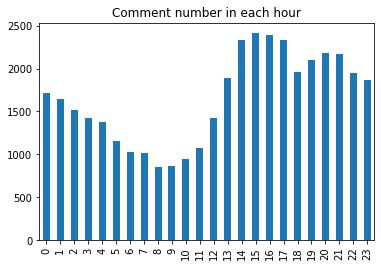

In [ ]:
# plot the bar chart
visual = comments['hour'].value_counts().sort_index()
ax = visual.plot.bar(title='Comment number in each hour')

Let's deal with the text

In [ ]:
# concat topic and comment together
posts_select = posts['Title'].rename({'Title':'text'})
comments_select = comments['Reply'].rename({'Reply':'text'})
alltext = pd.concat([posts_select,comments_select])

Reddit allows users to edit their post and there are some replies have been deleted or removed, and it will be marked as [removed] or [deleted]. Let's get rid of those rows.

In [ ]:
#use regular expression to deal with [removed] or [deleted]
patternDel = r'\[.*?\]'
filter = alltext.str.contains(patternDel)

In [ ]:
alltext = alltext[~filter]

In [ ]:
alltext.shape

(32837,)

In [ ]:
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

def preprocessing(columntitle):
    
    #convert all to lower case
    columntitle = columntitle.str.lower()
    #replace line breaks
    columntitle = columntitle.replace('\r', ' ').replace('\n', ' ')
    #replace punctuation
    columntitle = columntitle.apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) )
    #remove stop word
    columntitle = columntitle.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
    #remove link
    columntitle = columntitle.apply(lambda x: re.sub(r'\(?http\S+', '', str(x)))
    #Lemmatization 
    lemmatized = [lemmatizer.lemmatize(word) for word in columntitle]
    columntitle = columntitle.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
        ) )
    return columntitle
    

In [ ]:
alltext = preprocessing(alltext)

In [ ]:
#filter all len less than 1
mask = alltext.str.len() <=1
alltext = alltext[~mask]

In [ ]:
alltext = alltext.to_frame('text').reset_index(drop=True)

In [ ]:
alltext.head()

,text
0,number people coronavirus infection may dozen ...
1,least 11 tested blood donor stockholm covid19 ...
2,ending coronavirus lockdown will dangerous pro...
3,nyc health 18 death new york city without unde...
4,wearing mask protect coronavirus big mistake t...


## Cleanning is done, Let's get dirty and do some mining
#### Sentiment analysis with TextBlob
* opinion mining
* categorizing positive, negative or neutral opinion
* determining the attitude

In [ ]:
alltext['polarity'] = alltext.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
alltext['subjectivity'] = alltext.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [ ]:
#Label the sentiment by three levels
alltext.loc[alltext['polarity'] == 0, 'sentiment'] = 'neutral' 
alltext.loc[alltext['polarity'] > 0 , 'sentiment'] = 'positive'
alltext.loc[ alltext['polarity'] < 0 , 'sentiment'] = 'negative'
alltext.head()

,text,polarity,subjectivity,sentiment
0,number people coronavirus infection may dozen ...,0.325000,0.750000,positive
1,least 11 tested blood donor stockholm covid19 ...,-0.150000,0.233333,negative
2,ending coronavirus lockdown dangerous process ...,-0.600000,0.900000,negative
3,nyc health 18 death new york city without unde...,0.136364,0.454545,positive
4,wearing mask protect coronavirus big mistake t...,0.166667,0.200000,positive


In [ ]:
#sentiment distribution
alltext_count = alltext.groupby('sentiment').count()
alltext_count

,text,polarity,subjectivity
sentiment,,,
negative,7844,7844,7844
neutral,7599,7599,7599
positive,17208,17208,17208


Text(0.5, 1.0, 'Pre-train Classifier on Sentiment')

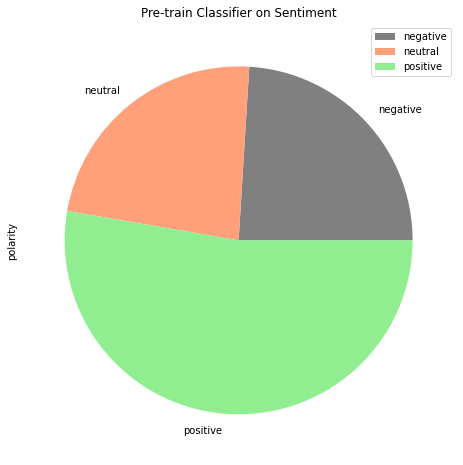

In [ ]:
#create a pie chart for sentiment distribution
colors = ['grey','lightsalmon','lightgreen']
plot = alltext_count.plot.pie(y='polarity',colors=colors, figsize=(8, 8))
plot.set_title("Pre-train Classifier on Sentiment")

**Again the text on Reddit is long, even the sentence contains good and well, it's hard to tell it's a positive sentiment**

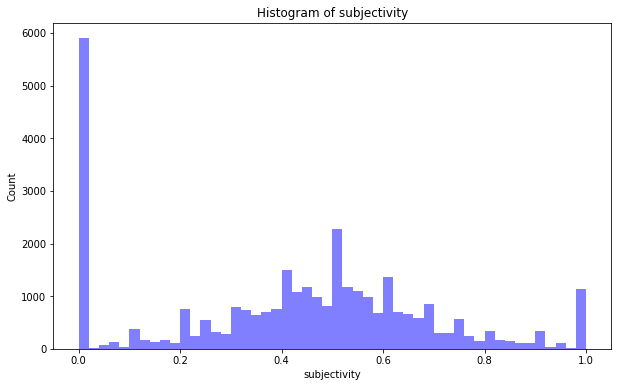

In [ ]:
# Histogram of Subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(alltext.subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('subjectivity')
plt.ylabel('Count')
plt.title('Histogram of subjectivity')
plt.show();

Subjectivity is from 0 to 1, and 0 is more about fact, while 1 is fully personal opinion. Most comment are factual information or with slight emotion rather than subjective opinion

### Bigrams

In [ ]:
#use . to seperate each sentence
all_text = alltext.text.str.cat(sep='. ')

In [ ]:
# word tokenize
all_text_token = nltk.word_tokenize(all_text)

In [ ]:
#get the bigram
bigram_measures = nltk.collocations.BigramAssocMeasures()
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('vice', 'versa'), ('los', 'angeles'), ('nitric', 'oxide'), ('chadox1', 'ncov19'), ('grasping', 'straw'), ('rheumatoid', 'arthritis'), ('faq', 'relating'), ('logistic', 'regression'), ('2080', 'ti'), ('pipe', 'dream')]


we can find some information from the bigram, but it doesn't make lots of sense

### Word Cloud

In [ ]:
# use reddit picture as the word cloud mask
reddit_mask = np.array(Image.open("/content/re2.png"))

In [ ]:
# a small tokenize function
def tokenize(text):
    # first tokenize by word 
    tokens = [word for word in nltk.word_tokenize(text)]
    tokens = [word for word in tokens if len(word)>2]
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

In [ ]:
all_text_wc = alltext['text'].apply(lambda x: tokenize(x))

In [ ]:
# create a dict to document word frequency
reddit_dict = {}

for words in all_text_wc:
    for word in words:
        if word not in reddit_dict:
            reddit_dict[word] = 1
        else:
            reddit_dict[word] += 1
            

In [ ]:
# common stop words & custom stop words
stopwords = set(STOPWORDS)
entries = ['think', 'even', 'know']

for key in entries:
    if key in reddit_dict:
        del reddit_dict[key]

(-0.5, 735.5, 1023.5, -0.5)

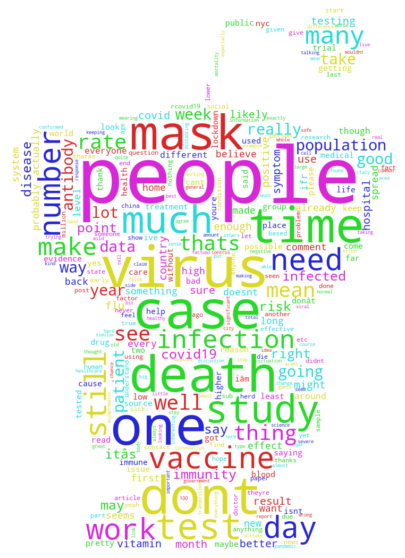

In [ ]:
#draw the word cloud
def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 70%%, 50%%)" % (60 * dictionary[word])
    return my_tf_color_func_inner

wc = WordCloud(max_words=300, background_color="white", stopwords=stopwords, 
               mask=reddit_mask, width=1000, height=800)
wc.generate_from_frequencies(frequencies=reddit_dict)
# wc.generate(full_words)
plt.figure(figsize=(20,10))
plt.imshow(wc.recolor(color_func=my_tf_color_func(reddit_dict)), interpolation="bilinear")
plt.axis("off")

As we can see from the pic that most of high frequency words are people, test,case, mask, vaccine, whihc are quite common in current pandemic situation.  

In [ ]:
alltext2 = alltext.loc[:,('text','sentiment')]

In [ ]:
alltext2.head()

,text,sentiment
0,number people coronavirus infection may dozen ...,positive
1,least 11 tested blood donor stockholm covid19 ...,negative
2,ending coronavirus lockdown will dangerous pro...,negative
3,nyc health 18 death new york city without unde...,positive
4,wearing mask protect coronavirus big mistake t...,positive


In [ ]:
alltext2.to_csv('reddit_label4.csv')